Importing modules

In [1]:
from dust_extinction.parameter_averages import CCM89
import astropy.units as u
import numpy as np
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
%matplotlib widget
from skimage.draw import line
from helpers import get_uJy_error_cube, get_pixel
from uncertainties import ufloat
from uncertainties.umath import log10

In [2]:
def find_peak_flux(fits_file, cube, error_cube, x, y, wavelength, width=0.003*u.um):
    '''
    Returns peak flux within the given width along with its error
    '''
    delta = width / 2
    wmin = wavelength - delta
    wmax = wavelength + delta
    subcube = cube.spectral_slab(wmin, wmax)
    slice = subcube.unmasked_data[:, y, x]
    error_subcube = error_cube.spectral_slab(wmin, wmax)
    error_slice = error_subcube.unmasked_data[:, y, x]
    
    # Handle edge case
    if np.all(np.isnan(slice)):
        
        return np.nan, np.nan
        
    
    idx_max = np.nanargmax(slice)
    return np.nanmax(slice), error_slice[idx_max]

In [3]:
def calculate_Av(fits_file, cube, error_cube, lambda1, lambda2, x, y):
    # Define extinction model with RV = 5.5 (McClure 2019)
    ext_model = CCM89(Rv=5.5)

    wavelengths = np.array([lambda1.value, lambda2.value]) * u.um
    x_values = 1/wavelengths

    # β = A(λ)/A(V)
    beta_vals = ext_model(x_values)
    beta_lambda1, beta_lambda2 = beta_vals[0], beta_vals[1]

    # Observed flux ratio
    Fobs1, error1 = find_peak_flux(fits_file, cube, error_cube, x, y, lambda1) 
    Fobs2, error2 = find_peak_flux(fits_file, cube, error_cube, x, y, lambda2)
    if (np.isnan(Fobs1) or np.isnan(Fobs2)):
        return np.nan, np.nan
    uF1 = ufloat(Fobs1.value, error1.value)
    uF2 = ufloat(Fobs2.value, error2.value)
    R_obs = uF1 / uF2
   
    # Intrinsic flux ratio, check database (values from paper)
    R_int = 0
    if lambda1 == 1.257*u.um:
        R_int = ufloat(1.155, 0.045)
    elif lambda1 == 1.321*u.um:
        R_int = ufloat(0.32, 0.01)
    elif lambda1 == 1.533*u.um:
        R_int = ufloat(1.245, 0.025)
    elif lambda1 == 1.599*u.um:
        R_int = ufloat(3.635, 0.205)

    # Apply extinction formula
    Av = (-2.5 * log10(R_obs / R_int)) / (beta_lambda1 - beta_lambda2)
    
    # print(f"A_V = {Av} mag")
    
    # SNR mask
    print(f"SNR1: {uF1.n/uF1.s:.2f}, SNR2: {uF2.n/uF2.s:.2f}")
    if uF1.n/uF1.s < 3 or uF2.n/uF2.s < 3:
         return np.nan, np.nan

    return Av.n, Av.s

In [4]:
centers_x = [25, 26, 27]
centers_y = [33, 38, 44]

In [5]:
# Avs = [calculate_Av('fits/4s3d.fits', 1.257*u.um, 1.644*u.um, centers_x[i], centers_y[i]) for i in range(3)]
# print([round(Av[0], 2) for Av in Avs])
# print([round(Av[1], 2) for Av in Avs])

# Av2 = calculate_Av('fits/4s3d.fits', 1.321*u.um, 1.644*u.um)
# Av3 = calculate_Av('fits/4s3d.fits', 1.533*u.um, 1.677*u.um)
# Av4 = calculate_Av('fits/4s3d.fits', 1.599*u.um, 1.712*u.um)

In [6]:
def plot_Avs(fits_file):
    cube = SpectralCube.read('../fits/subtracted_cube_full4.fits')
    error_cube = get_uJy_error_cube(fits_file)
    ra = 69.896675   * u.degree
    dec = 25.69561666667 * u.degree
    x1, y1 = get_pixel(cube, ra, dec) # starting point
    x1 = 24
    y1 = 26 # THESE ARE NOT REAL
    # print(x1, y1)
    
    x2 = 29
    y2 = 51
    rr, cc = line(y1, x1, y2, x2) # y, then x
    
    lines = [(1.257,1.644), (1.321,1.644), (1.533,1.677), (1.599,1.712)] * u.um
    colors = ['black', 'red', 'green', 'purple']
    labels = [f'{lines[i][0]}/{lines[i][1]}' for i in range(len(lines))]
    distances = np.sqrt((cc - x1)**2 + (rr - y1)**2)

    plt.figure(figsize=(9, 5))

    # Iterate over all line combinations
    for i in range(len(lines)):
        Avs = [calculate_Av(fits_file, cube, error_cube, lines[i][0], lines[i][1], rr[k], cc[k]) for k in range(len(rr))] # (Av_value, Av_error) tuples in a list
        # Plot Avs at each distance
        for k in range(len(rr)):
            if k == 0: # add just one label for each color
                plt.errorbar(distances[k], Avs[k][0], yerr=Avs[k][1], fmt='o', color=colors[i], label=labels[i])
            else:
                plt.errorbar(distances[k], Avs[k][0], yerr=Avs[k][1], fmt='o', color=colors[i])

    plt.xlabel('Distance from star (pixels)', fontsize=14)
    plt.ylabel('Visual Extinction $A_V$ (mag)', fontsize=14)
    plt.title('Extinction $A_V$ Along Jet Axis from Different Line Ratios', fontsize=16)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

SNR1: 8.78, SNR2: 18.02
SNR1: 6.85, SNR2: 18.48
SNR1: 4.15, SNR2: 15.37
SNR1: 4.51, SNR2: 13.03
SNR1: 5.27, SNR2: 3.58
SNR1: 4.64, SNR2: 9.03
SNR1: 5.25, SNR2: 10.06
SNR1: 3.56, SNR2: 7.19
SNR1: 4.38, SNR2: 6.28
SNR1: 3.29, SNR2: 8.06
SNR1: 3.88, SNR2: 5.00
SNR1: 5.64, SNR2: 3.78
SNR1: 2.34, SNR2: 2.70
SNR1: 4.24, SNR2: 4.69
SNR1: 3.90, SNR2: 3.00
SNR1: 1.65, SNR2: 2.03
SNR1: 2.32, SNR2: 3.16
SNR1: 1.08, SNR2: 4.91
SNR1: 3.66, SNR2: 4.82
SNR1: 2.15, SNR2: 1.90
SNR1: 2.28, SNR2: 2.38
SNR1: 3.38, SNR2: 1.81
SNR1: 1.57, SNR2: 2.91
SNR1: 5.31, SNR2: 18.02
SNR1: 3.24, SNR2: 18.48
SNR1: 1.87, SNR2: 15.37
SNR1: 2.61, SNR2: 13.03
SNR1: 3.35, SNR2: 3.58
SNR1: 3.98, SNR2: 9.03
SNR1: 3.13, SNR2: 10.06
SNR1: 1.37, SNR2: 7.19
SNR1: 1.55, SNR2: 6.28
SNR1: 4.23, SNR2: 8.06
SNR1: 3.54, SNR2: 5.00
SNR1: 1.40, SNR2: 3.78
SNR1: 2.48, SNR2: 2.70
SNR1: 1.52, SNR2: 4.69
SNR1: 3.82, SNR2: 3.00
SNR1: 3.58, SNR2: 2.03
SNR1: 3.72, SNR2: 3.16
SNR1: 1.27, SNR2: 4.91
SNR1: 0.85, SNR2: 4.82
SNR1: 0.93, SNR2: 1.90
S

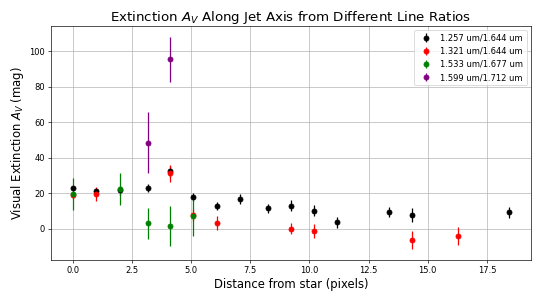

In [8]:
plt.rcParams['figure.dpi'] = 60 # Changes widget size
plot_Avs('../fits/4s3d.fits')